In [1]:
from qaravan.core import Circuit, QubitNoise, PauliNoise, circ_to_mat
from qaravan.core.gates import *
from qaravan.core.paulis import *
from qaravan.tensorQ import DensityMatrixSim, expectation, partial_trace, StatevectorSim, all_zero_sv
from qaravan.core.utils import pretty_print_dm, fidelity, string_to_sv, pretty_print_sv
from qaravan.core.circuits import shift_gate_list
from qaravan.core.hamiltonians import TFI
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Phase learning

In [42]:
t1 = 100
t2 = 200
one_qubit_time = 10
two_qubit_time = 50
nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)

In [43]:
mag_exact = []
for t in np.arange(0, 2 * np.pi, 0.1):
    gate_list = [H(0), RZ(0, t), H(0)]
    circ = Circuit(gate_list, 1)
    sim = DensityMatrixSim(circ, nm=None)
    mag = [pauli_Z]

    mag_exact.append(sim.local_expectation(mag))

In [44]:
mag_noisy = []
for t in np.arange(0, 2 * np.pi, 0.1):
    gate_list = [H(0), RZ(0, t), H(0)] 
    circ = Circuit(gate_list, 1)
    sim = DensityMatrixSim(circ, nm=nm)
    mag = [pauli_Z]

    mag_noisy.append(sim.local_expectation(mag))

In [47]:
init_list = [np.array([[1,0], [0,0]]), np.array([[1,0], [0,0]]), 0.5*np.array([[1,0], [0,1]])]
init_state = reduce(np.kron, init_list)

mag_corrected = []
for t in np.arange(0, 2 * np.pi, 0.1):
    cswap = [H(0), CUGate([1,2,0], SWAP([1,2]), 3)] 
    u = [H(1), H(2), RZ(1, t), RZ(2, t), H(1), H(2)]
    cswapd = [CUGate([1,2,0], SWAP([1,2]), 3), H(0)]

    circ = Circuit(cswap + u + cswapd, 3) 
    circ = circ.build(nm=nm)

    # remove noise for CSwap layers
    circ.layers[1] = circ.layers[1][0:1]
    circ.layers[-2] = circ.layers[-2][0:1]
    circ.layers[0] = circ.layers[0][0:1]
    circ.layers[-1] = circ.layers[-1][0:1]

    sim = DensityMatrixSim(circ, nm=nm, init_state=init_state)
    num_op = [pauli_Z, pauli_Z, pauli_I] 
    denom_op = [pauli_Z, pauli_I, pauli_I]
    mag = sim.local_expectation(num_op)/sim.local_expectation(denom_op)
    mag_corrected.append(mag)

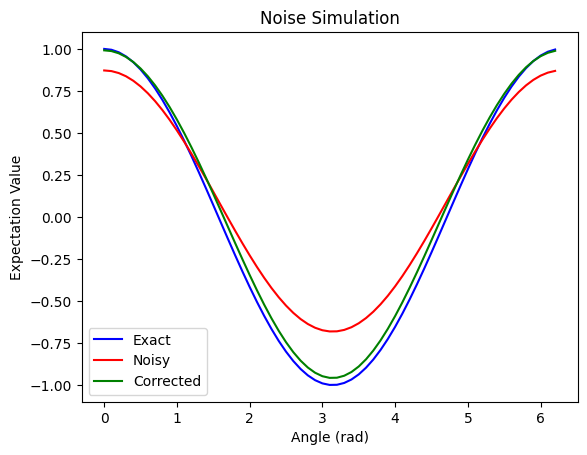

In [48]:
plt.plot(np.arange(0, 2 * np.pi, 0.1), mag_exact, label='Exact', color='blue')
plt.plot(np.arange(0, 2 * np.pi, 0.1), mag_noisy, label='Noisy', color='red')
plt.plot(np.arange(0, 2 * np.pi, 0.1), mag_corrected, label='Corrected', color='green')
plt.title('Noise Simulation')
plt.xlabel('Angle (rad)')
plt.ylabel('Expectation Value')
plt.legend()

# TFI evolution

In [2]:
def cswap_network(n):
    gate_list = []
    for _ in range(n):
        for i in range(2*n-2): 
            gate_list += [CUGate([i+1, i+2, i], SWAP([i+1, i+2]), n), SWAP([i, i+1])]

        gate_list += [CUGate([2*n-1, 2*n, 2*n-2], SWAP([n, n+1]), n)]
        gate_list += [SWAP([2*n-3-i, 2*n-2-i]) for i in range(2*n-2)]

    return gate_list

def noisy_mag(ham, time, step_size, noise_rate): 
    num_steps = int(time/step_size)
    circ = ham.trotter_circ(step_size, num_steps, order=2)

    t1 = 100/noise_rate
    t2 = 75/noise_rate
    one_qubit_time = 0.04
    two_qubit_time = 0.5
    nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)
    sim = DensityMatrixSim(circ, nm=nm)
    mag = [pauli_Z] * ham.num_sites
    return sim.local_expectation(mag)

def vcp_mag(ham, time, step_size, noise_rate): 
    num_steps = int(time/step_size)
    circ = ham.trotter_circ(step_size, num_steps, order=2)
    n = ham.num_sites

    t1 = 100/noise_rate
    t2 = 75/noise_rate
    one_qubit_time = 0.04
    two_qubit_time = 0.5
    nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)

    top_qubits = np.zeros((2**(n+1), 2**(n+1)))
    top_qubits[0,0] = 1
    bottom_qubits = np.eye(2**n)/(2**n)
    init_state = np.kron(top_qubits, bottom_qubits)

    cswap = [H(0)] + cswap_network(n)
    u = shift_gate_list(copy.deepcopy(circ), 1) + shift_gate_list(copy.deepcopy(circ), n+1) 
    cswapd = cswap[::-1]
    new_circ = Circuit(cswap + u + cswapd)
    sim = DensityMatrixSim(new_circ, init_state=init_state, nm=nm)
    
    num_op = [pauli_Z] + [pauli_Z]*n + [pauli_I]*n
    denom_op = [pauli_Z] + [pauli_I]*2*n
    return sim.local_expectation(num_op)/sim.local_expectation(denom_op)

In [3]:
# is cswap network correct?
gate_list = [H(0), X(1), X(4), X(6), X(7)] + cswap_network(4)
circ = Circuit(gate_list)
pretty_print_sv(circ_to_mat(circ) @ string_to_sv('0'*9, 2), 2)

'0.7071|010010110⟩ + 0.7071|101101001⟩'

In [4]:
n = 4
tfi = TFI(n, 1, 0.75)
times = np.arange(0.2, 5.0, 0.2)
step_size = 0.1
mag = [pauli_Z] * n

In [5]:
mag_list_exact = []
for time in times:
    init_state = all_zero_sv(n, dense=True)
    final_state = tfi.evolve(time, init_state)
    mag_full_op = embed_operator(n, [0,1,2,3], mag)

    exp_val = final_state.conj().T @ mag_full_op @ final_state
    mag_list_exact.append(exp_val.real) 

In [6]:
mag_list_trotter = []
for time in times:
    num_steps = int(time/step_size)
    circ = tfi.trotter_circ(step_size, num_steps, order=2)
    sim = StatevectorSim(circ)
    exp_val = sim.local_expectation(mag)
    mag_list_trotter.append(exp_val)

In [7]:
mag_list_thermal1 = []
mag_list_thermal2 = []
for time in times:
    mag_list_thermal1.append(noisy_mag(tfi, time, step_size, 0.25))
    mag_list_thermal2.append(noisy_mag(tfi, time, step_size, 1.0))

In [8]:
mag_list_corrected1 = []
mag_list_corrected2 = []
for time in tqdm(times):
    mag_list_corrected1.append(vcp_mag(tfi, time, step_size, 0.25))
    mag_list_corrected2.append(vcp_mag(tfi, time, step_size, 1.0))

  0%|          | 0/24 [00:00<?, ?it/s]

In [14]:
import pickle
with open("vcp_4_data.pickle", "wb") as f:
    pickle.dump([times, mag_list_corrected1, mag_list_corrected2, mag_list_thermal1, mag_list_thermal2], f)

Text(0.5, 1.0, 'simulation of VCP for TFI evolution, fixed Trotter step size')

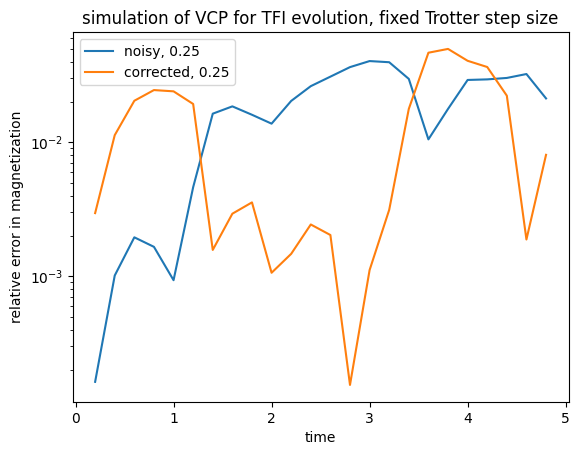

In [17]:
err_thermal1 = [np.abs(t-tt)/np.abs(tt) for t, tt in zip(mag_list_thermal1, mag_list_trotter)]
err_thermal2 = [np.abs(t-tt)/np.abs(tt) for t, tt in zip(mag_list_thermal2, mag_list_trotter)]
err_corrected1 = [np.abs(t-tt)/np.abs(tt) for t, tt in zip(mag_list_corrected1, mag_list_trotter)]
err_corrected2 = [np.abs(t-tt)/np.abs(tt) for t, tt in zip(mag_list_corrected2, mag_list_trotter)]

plt.plot(times, err_thermal1, label='noisy, 0.25')
#plt.plot(times, err_thermal2, label='noisy, 1.0')
plt.plot(times, err_corrected1, label='corrected, 0.25')
#plt.plot(times, err_corrected2, label='corrected, 1.0')
plt.legend()
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('relative error in magnetization')
plt.title('simulation of VCP for TFI evolution, fixed Trotter step size')

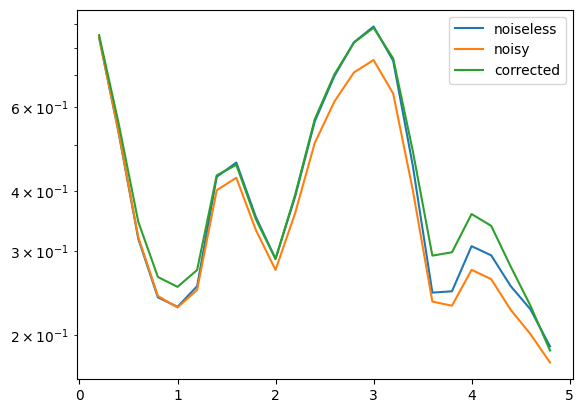

In [15]:
plt.plot(times, mag_list_trotter, label='noiseless')
plt.plot(times, mag_list_thermal2, label='noisy')
plt.plot(times, mag_list_corrected2, label='corrected')
plt.legend()
plt.yscale('log')

Text(0.5, 1.0, 'TFI evolution, fixed step size, various noise rates')

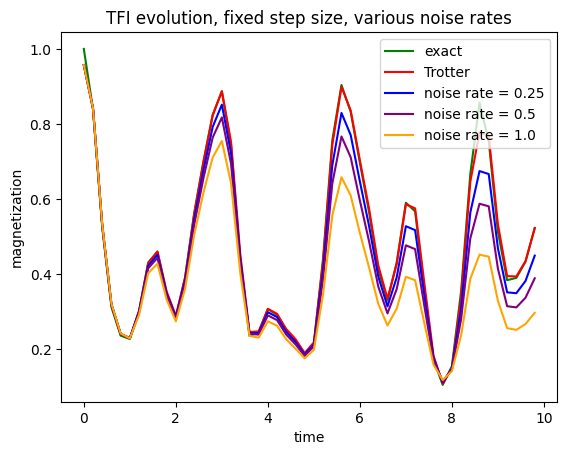

In [19]:
plt.plot(times, mag_list_exact, label='exact', color='green')
plt.plot(times, mag_list_trotter, label='Trotter', color='red')
plt.plot(times, mag_list_thermal1, label='noise rate = 0.25', color='blue')
plt.plot(times, mag_list_thermal2, label='noise rate = 0.5', color='purple')
plt.plot(times, mag_list_thermal3, label='noise rate = 1.0', color='orange')
plt.legend()
plt.xlabel('time')
plt.ylabel('magnetization')
plt.title('TFI evolution, fixed step size, various noise rates')

In [11]:
time = 3

# first we do noiseless
num_steps = int(time/step_size)
circ = tfi.trotter_circ(step_size, num_steps, order=2)
sim = DensityMatrixSim(circ, nm=None)
exp_val = sim.local_expectation(mag)
print(exp_val)

# next we do noisy
t1 = 40000
t2 = 80000
one_qubit_time = 10
two_qubit_time = 50
nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)
sim = DensityMatrixSim(circ, nm=nm)
exp_val = sim.local_expectation(mag)
print(exp_val)

# next we do noiseless but with VCP 
top_qubits = np.zeros((2**5, 2**5))
top_qubits[0,0] = 1
bottom_qubits = np.eye(2**4)/(2**4)
init_state = np.kron(top_qubits, bottom_qubits)

cswap = [H(0)] + cswap_network(4)
u = shift_gate_list(copy.deepcopy(circ), 1) + shift_gate_list(copy.deepcopy(circ), 5) 
cswapd = cswap[::-1]
new_circ = Circuit(cswap + u + cswapd)

num_op = [pauli_Z] + [pauli_Z]*4 + [pauli_I]*4
denom_op = [pauli_Z] + [pauli_I]*8
sim = DensityMatrixSim(new_circ, init_state=init_state, nm=None)
exp_val = sim.local_expectation(num_op)/sim.local_expectation(denom_op)
print(exp_val)

# next we do noisy but with VCP
sim = DensityMatrixSim(new_circ, init_state=init_state, nm=nm)
exp_val = sim.local_expectation(num_op)/sim.local_expectation(denom_op)
print(exp_val)

0.8872165876832157
0.8353061370949251
0.8872165876831963
0.8844437129616605


In [22]:
time = 1.0

# first we do noiseless
num_steps = int(time/step_size)
circ = tfi.trotter_circ(step_size, num_steps, order=2)
sim = DensityMatrixSim(circ, nm=None)
exp_val = sim.local_expectation(mag)
print(exp_val)

# next we do noisy
t1 = 40000
t2 = 80000
one_qubit_time = 10
two_qubit_time = 50
nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time, coupling=0.0)
sim = DensityMatrixSim(circ, nm=nm)
exp_val = sim.local_expectation(mag)
print(exp_val)

# next we do noiseless but with VCP 
top_qubits = np.zeros((2**5, 2**5))
top_qubits[0,0] = 1
bottom_qubits = np.eye(2**4)/(2**4)
init_state = np.kron(top_qubits, bottom_qubits)

cswap = [H(0)] + cswap_network(4)
u = shift_gate_list(copy.deepcopy(circ), 1) + shift_gate_list(copy.deepcopy(circ), 5) 
cswapd = cswap[::-1]
new_circ = Circuit(cswap + u + cswapd)

num_op = [pauli_Z] + [pauli_Z]*4 + [pauli_I]*4
denom_op = [pauli_Z] + [pauli_I]*8
sim = DensityMatrixSim(new_circ, init_state=init_state, nm=None)
exp_val = sim.local_expectation(num_op)/sim.local_expectation(denom_op)
print(exp_val)

# next we do noisy but with VCP
sim = DensityMatrixSim(new_circ, init_state=init_state, nm=nm)
exp_val = sim.local_expectation(num_op)/sim.local_expectation(denom_op)
print(exp_val)

0.22869645790813076
0.228947422413847
0.22869645790812917
0.24108753059845203


# QAOA